# Trends In AI FEDERATED Learning Spam & Ham
Goudantov Bers, Van Camp Loïc

In [72]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# Load dataset

In [73]:
data_path = 'spam.csv'
data = pd.read_csv(data_path, usecols=[0, 1], names=['label', 'text'], skiprows=1, encoding='ISO-8859-1')
data['label'] = data['label'].map({'ham': 0, 'spam': 1})  # Converteer labels naar binair

# 1. Datasimulatie: Verdeel de dataset over meerdere clients met meer heterogeniteit

In [74]:
def simulate_clients(data, n_clients=5, heterogeneity=0.3):
    clients = {}
    for i in range(n_clients):
        client_data = shuffle(data)
        spam_ratio = heterogeneity * i / (n_clients - 1) + (1 - heterogeneity) * 0.5
        spam = client_data[client_data['label'] == 1].sample(frac=spam_ratio, random_state=42)
        ham = client_data[client_data['label'] == 0].sample(frac=1 - spam_ratio, random_state=42)
        clients[f'client_{i}'] = pd.concat([spam, ham]).sample(frac=1)
    return clients

clients = simulate_clients(data, n_clients=5, heterogeneity=0.6)

# 2. Lokaal model training met Regularization en Hyperparameter Tuning

In [75]:
def train_local_model(client_data, vectorizer=None, epsilon=1.0):
    X_train, X_test, y_train, y_test = train_test_split(client_data['text'], client_data['label'], test_size=0.2, random_state=42)
    if vectorizer is None:
        vectorizer = TfidfVectorizer(ngram_range=(1, 2))  # Gebruik unigrams en bigrams
        X_train = vectorizer.fit_transform(X_train)
    else:
        X_train = vectorizer.transform(X_train)
    
    # Logistic Regression met Cross Validation voor hyperparameter tuning
    model = LogisticRegressionCV(max_iter=2000, cv=10, class_weight='balanced', solver='liblinear', multi_class='ovr', n_jobs=-1)
    model.fit(X_train, y_train)
    
    # Pas differential privacy toe door ruis toe te voegen aand de gewichten
    noise = np.random.laplace(0, epsilon, model.coef_.shape)  # Laplace ruis voor differential privacy
    model.coef_ += noise
    
    return model, vectorizer

# 3. Evalueer de model

In [76]:
def evaluate_model(data, vectorizer, weights, threshold=0.5):
    X_test = vectorizer.transform(data['text'])
    y_test = data['label']
    
    # Pas de model gewichten toe aan de test data
    scores = X_test @ weights.T
    y_pred = (scores > threshold).astype(int)
    
    # Evalueer de metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    return accuracy, precision, recall, confusion_matrix(y_test, y_pred)

# 4. Verbeterd Federated Averaging met gewogen aggregatie op basis van modelprestaties

In [77]:
def federated_averaging(models, client_data, vectorizer):
    avg_weights = None  # Gemiddelde gewichten initialiseren
    total_samples = 0  # Totale gewogen samples
    client_performance = {}  # Dictionary voor het opslaan van de prestaties van elke client
    
    # Doorloop alle clients en voer gewogen aggregatie uit
    for client, model in models.items():
        n_samples = len(client_data[client])  # Aantal samples voor deze client
        weights = model.coef_  # Haal de gewichten van het model op
        accuracy = evaluate_model(client_data[client], vectorizer, weights)[0]  # Verkrijg de nauwkeurigheid van het model
        
        # Sla de prestaties (nauwkeurigheid) van de client op
        client_performance[client] = accuracy
        
        # Weeg de modelgewichten op basis van het aantal samples en de nauwkeurigheid van het model
        weight_factor = n_samples * accuracy  # Hoe hoger de nauwkeurigheid, hoe meer invloed
        if avg_weights is None:
            avg_weights = weights * weight_factor  # Bij de eerste iteratie stel je de gewogen gewichten in
        else:
            avg_weights += weights * weight_factor  # Voeg de gewogen gewichten toe bij volgende iteraties
        
        # Voeg het gewogen aantal samples toe aan de totale samples
        total_samples += weight_factor
    
    # Bereken de gemiddelde gewichten door te delen door het totaal aantal gewogen samples
    avg_weights /= total_samples
    return avg_weights  # Retourneer de gemiddelde gewichten

# Train een model voor elke client met Differential Privacy

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 1: Federated Model - Accuracy: 0.9847396768402155, Precision: 0.9050279329608939, Recall: 1.0
Confusion Matrix:
[[935  17]
 [  0 162]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 2: Federated Model - Accuracy: 0.9847396768402155, Precision: 0.9096774193548387, Recall: 0.9791666666666666
Confusion Matrix:
[[956  14]
 [  3 141]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 3: Federated Model - Accuracy: 0.9748653500897666, Precision: 0.8545454545454545, Recall: 0.9724137931034482
Confusion Matrix:
[[945  24]
 [  4 141]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 4: Federated Model - Accuracy: 0.9829443447037702, Precision: 0.9005847953216374, Recall: 0.9871794871794872
Confusion Matrix:
[[941  17]
 [  2 154]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 5: Federated Model - Accuracy: 0.9802513464991023, Precision: 0.8717948717948718, Recall: 0.9855072463768116
Confusion Matrix:
[[956  20]
 [  2 136]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 6: Federated Model - Accuracy: 0.973967684021544, Precision: 0.8586956521739131, Recall: 0.9813664596273292
Confusion Matrix:
[[927  26]
 [  3 158]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 7: Federated Model - Accuracy: 0.9847396768402155, Precision: 0.9032258064516129, Recall: 0.9859154929577465
Confusion Matrix:
[[957  15]
 [  2 140]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 8: Federated Model - Accuracy: 0.9847396768402155, Precision: 0.9119496855345912, Recall: 0.9797297297297297
Confusion Matrix:
[[952  14]
 [  3 145]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 9: Federated Model - Accuracy: 0.9775583482944344, Precision: 0.85, Recall: 0.9927007299270073
Confusion Matrix:
[[953  24]
 [  1 136]]


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1914: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegressionCV(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_lo

Round 10: Federated Model - Accuracy: 0.981149012567325, Precision: 0.8841463414634146, Recall: 0.9863945578231292
Confusion Matrix:
[[948  19]
 [  2 145]]


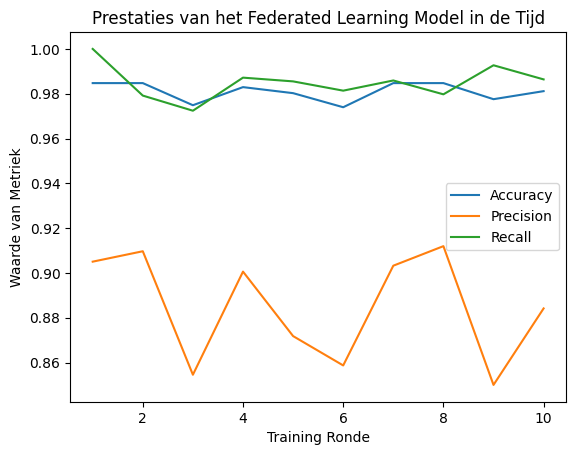

In [78]:
def plot_performance(history):
    rounds = np.arange(1, len(history) + 1)  # Maak een array van de ronden (1 tot aantal rondes)
    accuracies = [h['accuracy'] for h in history]  # Haal de nauwkeurigheid op voor elke ronde
    precisions = [h['precision'] for h in history]  # Haal de precisie op voor elke ronde
    recalls = [h['recall'] for h in history]  # Haal de recall op voor elke ronde
    
    # Maak de grafieken voor nauwkeurigheid, precisie en recall
    plt.plot(rounds, accuracies, label="Accuracy")  # Plot de nauwkeurigheid
    plt.plot(rounds, precisions, label="Precision")  # Plot de precisie
    plt.plot(rounds, recalls, label="Recall")  # Plot de recall
    plt.xlabel("Training Ronde")  # Zet de X-as label
    plt.ylabel("Waarde van Metriek")  # Zet de Y-as label
    plt.legend()  # Toon de legenda met de labels
    plt.title("Prestaties van het Federated Learning Model in de Tijd")  # Zet de titel voor de grafiek
    plt.show()  # Toon de grafiek

# Bijhouden van prestaties per ronde voor visualisatie
history = []

# Federated learning loop met tracking van de prestaties
for round_num in range(1, 11):  # 10 rondes van federated learning
    local_models = {}  # Dictionary voor de lokale modellen
    for client, client_data in clients.items():
        local_model, vectorizer = train_local_model(client_data, vectorizer, epsilon=1.0)
        local_models[client] = local_model  # Bewaar het lokale model voor deze client

    # Aggregatie van modelgewichten met gewogen averaging
    central_weights = federated_averaging(local_models, clients, vectorizer)

    # Verdeel de testdata en evalueer het federated model
    central_test_data = shuffle(data.sample(frac=0.2))  # Verdeel 20% van de data als testdata
    accuracy, precision, recall, cm = evaluate_model(central_test_data, vectorizer, central_weights)
    
    # Sla de resultaten van deze ronde op in de geschiedenis
    history.append({
        'round': round_num,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    })
    
    # Print de evaluatieresultaten van de federated model
    print(f"Round {round_num}: Federated Model - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
    print(f"Confusion Matrix:\n{cm}")

# Roep de functie aan om de prestaties te visualiseren
plot_performance(history)